# ConvNet Abstraction

## Overview

In [32]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
import os
import sys
from typing import Tuple

from dataclasses import dataclass

if '' in sys.path:
    sys.path.remove('')

module_path = os.path.abspath(os.path.join('../python'))
if module_path not in sys.path:
    sys.path.append(module_path)

print(sys.path)

import networkx as nx

from graphPlot import drawGraph
from const import *

plt.rcParams['figure.figsize'] = [10, 10]
print(plt.rcParams['figure.figsize'])

['/home/shared/anaconda3/lib/python36.zip', '/home/shared/anaconda3/lib/python3.6', '/home/shared/anaconda3/lib/python3.6/lib-dynload', '/home/peng/.local/lib/python3.6/site-packages', '/home/shared/anaconda3/lib/python3.6/site-packages', '/home/shared/anaconda3/lib/python3.6/site-packages/IPython/extensions', '/home/peng/.ipython', '/home/peng/git/convnet-abstraction/python']
[10.0, 10.0]


## DataAugmentation

Let's do a small experiment, here is an augmentation in python

In [34]:

import aug2conv
from mxnet.ndarray import NDArray
from mxnet.gluon.data import DataLoader
from mxnet.gluon.nn import Sequential

data = aug2conv.getData()

imgs: NDArray
imgs, ls = next(data.__iter__())

(10, 10)


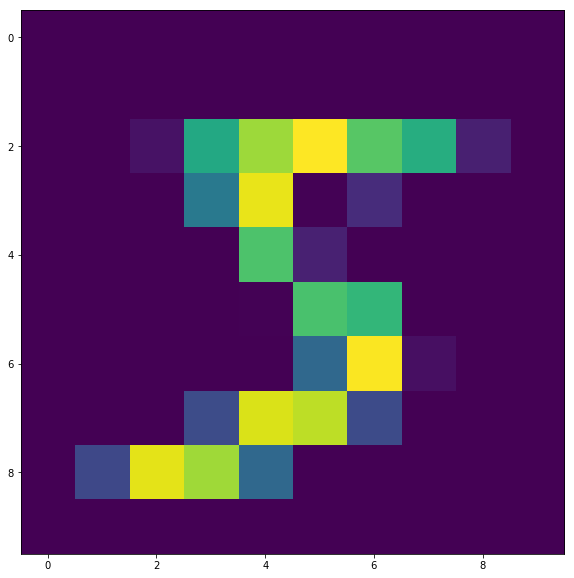

In [35]:
img1 = imgs[0].squeeze(axis=(0,))
print(img1.shape)
plt.imshow(img1.asnumpy())

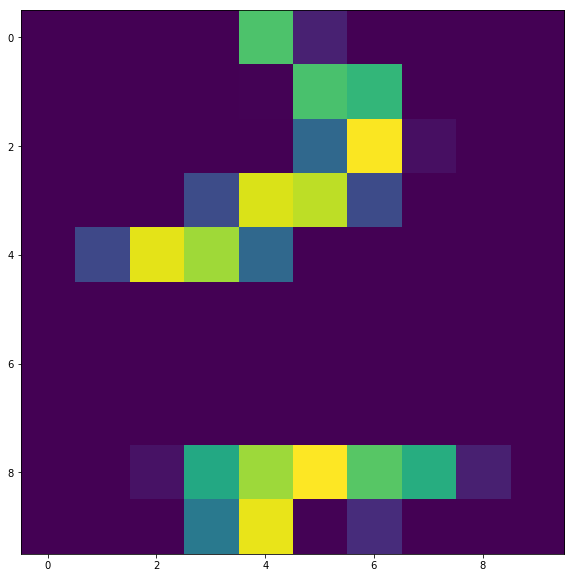

In [36]:

auged = img1.copy()

auged = aug2conv.shiftY(auged, 6)
plt.imshow(auged.asnumpy())

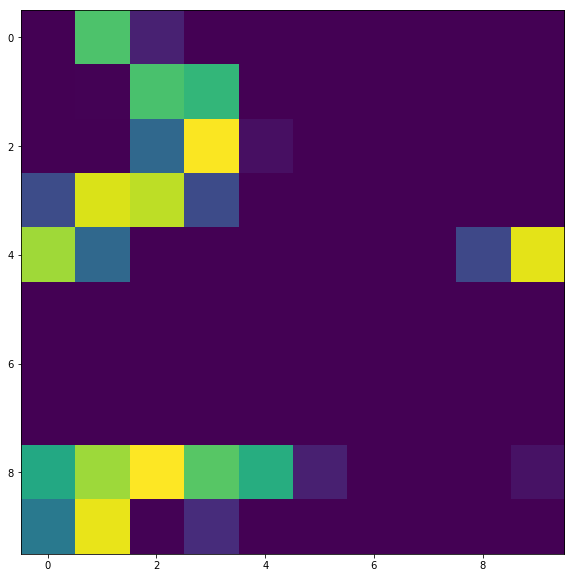

In [37]:
auged = aug2conv.shiftX(auged, 7)
plt.imshow(auged.asnumpy())

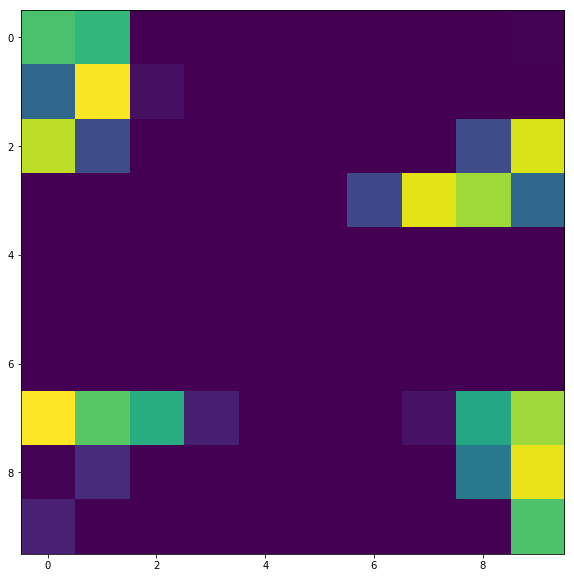

In [38]:
augmenter = aug2conv.Augmenter(img1)
auggedUp = augmenter.aug1(img1)
plt.imshow(auggedUp[55, :, :].asnumpy())

In [39]:

from mxnet import autograd, initializer
import mxnet.gluon as glu
from pathlib import Path

lossFn = glu.loss.SoftmaxCrossEntropyLoss()

In [40]:

@dataclass
class HWY(glu.HybridBlock):

    def __init__(self, layers: Tuple):
        super(HWY, self).__init__()
        self.delegate = glu.nn.HybridSequential()
        self.delegate.add(*layers)

    def getLayers(self):
        return list(self.delegate)

    def hybrid_forward(self, F, x, *args, **kwargs):
        r = self.delegate.forward(x, *args)
        return r + x.reshape(r.shape)

    def __hash__(self):
        return hash(self.delegate)

In [41]:
# Build a feed-forward network
def newModel() -> glu.nn.HybridSequential:
    model = glu.nn.HybridSequential()
    # with model.name_scope():
    model.add(
        # HWY((
        #     glu.nn.Dense(100),
        #     glu.nn.Activation('relu')
        # )),
        HWY((
            glu.nn.Dense(100),
            glu.nn.Activation('relu')
        )),
        glu.nn.Dense(10)
    )

    init = initializer.Uniform()
    # init = initializer.One()
    model.initialize(ctx=CTX, init=init)
    return model

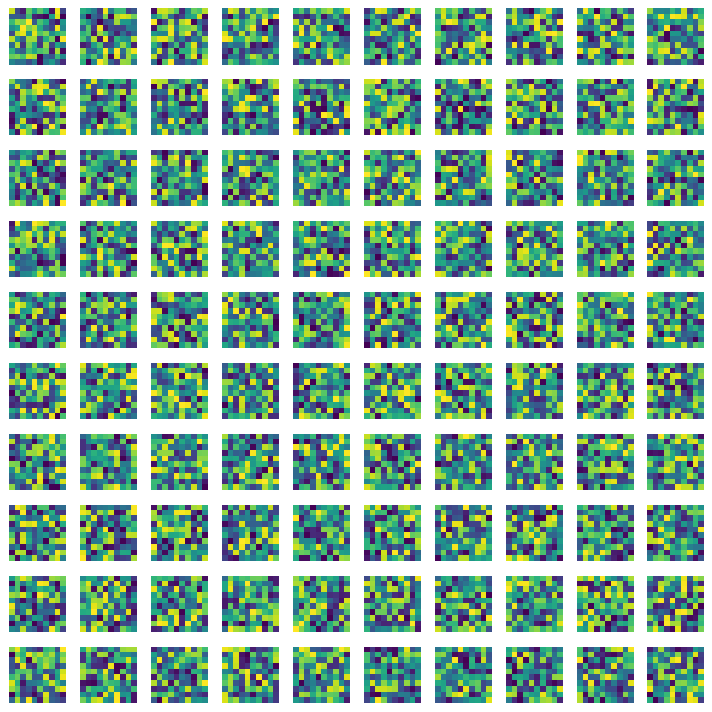

In [42]:

import utils.helper

model = newModel()
model.forward(imgs.as_in_context(CTX))

fc1 = model[0].getLayers()[0]
utils.helper.viewFCWeights(fc1)

In [43]:
def train(
        name: str,
        loader: DataLoader = data,
        lossTarget=0.15,
        maxEpochs=100,
        aug=lambda v: v
) -> Sequential:
    model = newModel()

    filePath = f"{os.getcwd()}/{MODEL_CHKPNT}/{name}.model"

    try:
        model.load_parameters(filePath)
        print(f">> model loaded from: {filePath}")
    except Exception as ee:
        print(f">> model being learned from scratch: {filePath}")

        optimizer = glu.Trainer(model.collect_params(), 'adam', {'learning_rate': 0.01})

        # cc = 0
        for epoch in range(maxEpochs):
            sumLoss = 0
            for imgs, labels in loader:
                # print(f"loading batch {cc} - of {imgs.shape[0]}")
                # cc += 1
                imgs = imgs.squeeze(axis=(1,))

                imgs, labels = aug((imgs, labels))
                imgs = imgs.as_in_context(CTX)
                labels = labels.as_in_context(CTX)

                with autograd.record():
                    output = model.forward(imgs)
                    loss = lossFn(output, labels)

                loss.backward()
                sumLoss += loss.mean().asscalar()

                optimizer.step(imgs.shape[0] / 2)

            else:
                print(f"Training loss: {sumLoss / len(loader)}")

            if sumLoss / len(loader) <= lossTarget:
                break

        os.makedirs(Path(filePath).parent, exist_ok=True)
        model.save_parameters(filePath)
        print(f">>> model saved to: {filePath}")

    return model

>> model being learned from scratch: /home/peng/git/convnet-abstraction/slide/.model_checkpoints/raw.model
Training loss: 0.42720330757563557
Training loss: 0.27297454088457673
Training loss: 0.22985149341335556
Training loss: 0.21820263539466744
Training loss: 0.20679077071779128
Training loss: 0.19734475316394415
Training loss: 0.18969974966584716
Training loss: 0.188031762375681
Training loss: 0.18983765451142243
Training loss: 0.18126356281858405
Training loss: 0.17829341093884477
Training loss: 0.17715493296963106
Training loss: 0.1726966877415804
Training loss: 0.17007913894001653
Training loss: 0.17053673817140202
Training loss: 0.16898295916217282
Training loss: 0.1675536708451057
Training loss: 0.16060401693950577
Training loss: 0.16713855808931163
Training loss: 0.16138572452839578
Training loss: 0.16225038347011214
Training loss: 0.163201630754304
Training loss: 0.16004555779203936
Training loss: 0.16257366952029612
Training loss: 0.16121239875972485
Training loss: 0.1558802

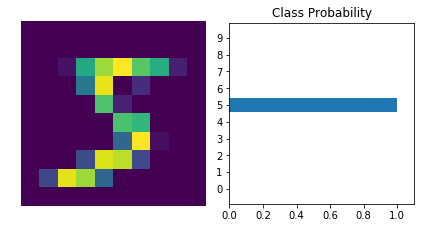

In [44]:

model = train("raw")

logits = model.forward(imgs.as_in_context(CTX))
ps = mx.ndarray.softmax(logits, axis=1)

utils.helper.view_classify(imgs[0], ps[0])

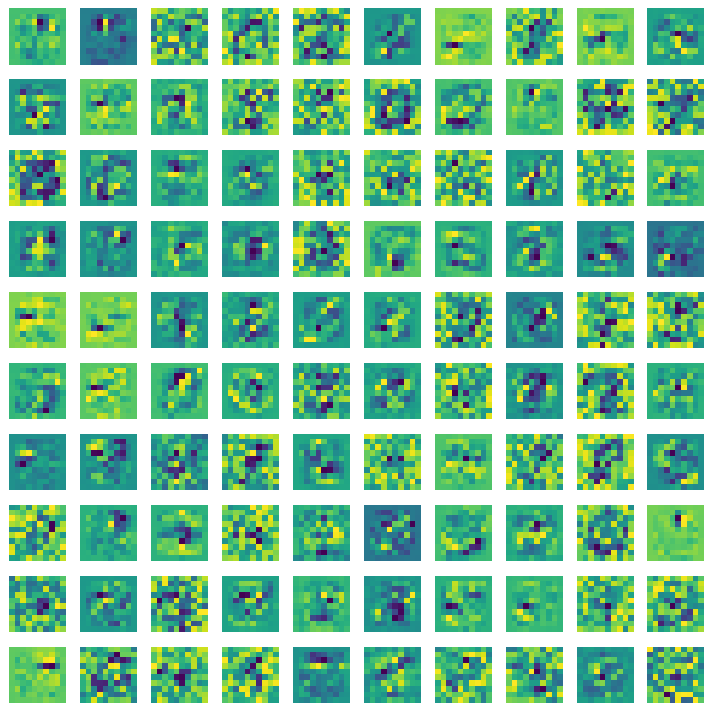

In [45]:

fc1 = model[0].getLayers()[0]
utils.helper.viewFCWeights(fc1)

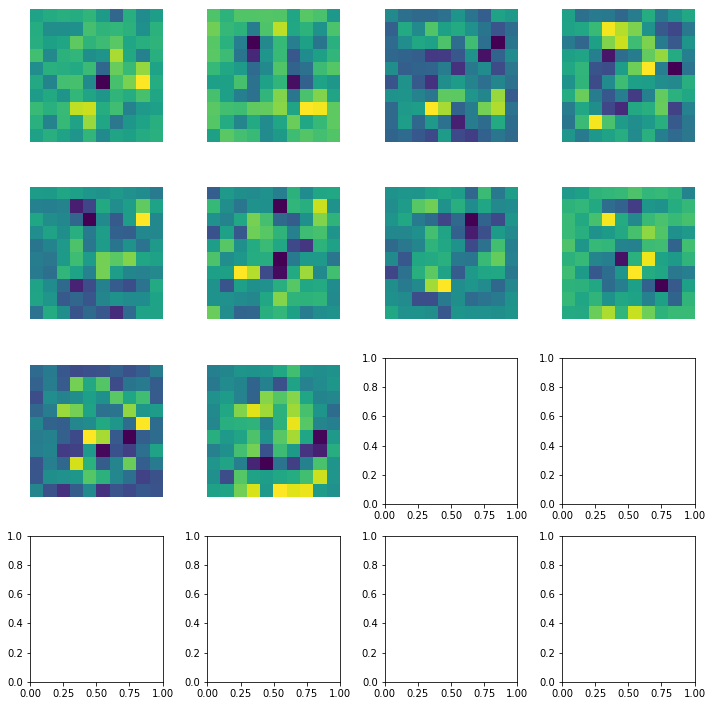

In [46]:

fc3 = model[1]
utils.helper.viewFCWeights(fc3)

In [47]:

# now let's enable augmentation

augModel = train("aug", aug=augmenter.augFirstTuple)

>> model being learned from scratch: /home/peng/git/convnet-abstraction/slide/.model_checkpoints/aug.model
Training loss: 2.986925279662045
Training loss: 2.9371804734950127
Training loss: 2.9259135276238037
Training loss: 2.911434298718789
Training loss: 2.906729466434735
Training loss: 2.8957601582397148
Training loss: 2.887002261248288
Training loss: 2.878721928839554
Training loss: 2.870856229755988
Training loss: 2.8634254518252953
Training loss: 2.856431430972207
Training loss: 2.8498572850865975
Training loss: 2.843678435942194
Training loss: 2.8378684837251966
Training loss: 2.832402014719652
Training loss: 2.8272548762958314
Training loss: 2.822404627304977
Training loss: 2.8178307282994552
Training loss: 2.813513888486985
Training loss: 2.8094362601447207
Training loss: 2.8055815345871804
Training loss: 2.801934587231069
Training loss: 2.798481402986212
Training loss: 2.7952090674070025
Training loss: 2.7921056766817562
Training loss: 2.7891599808626975
Training loss: 2.78636

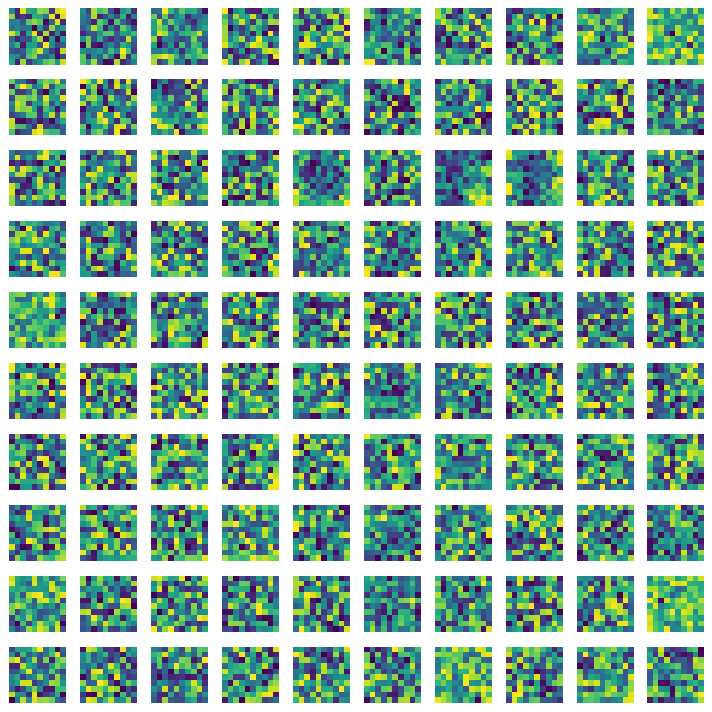

In [48]:

fc1 = augModel[0].getLayers()[0]
utils.helper.viewFCWeights(fc1)

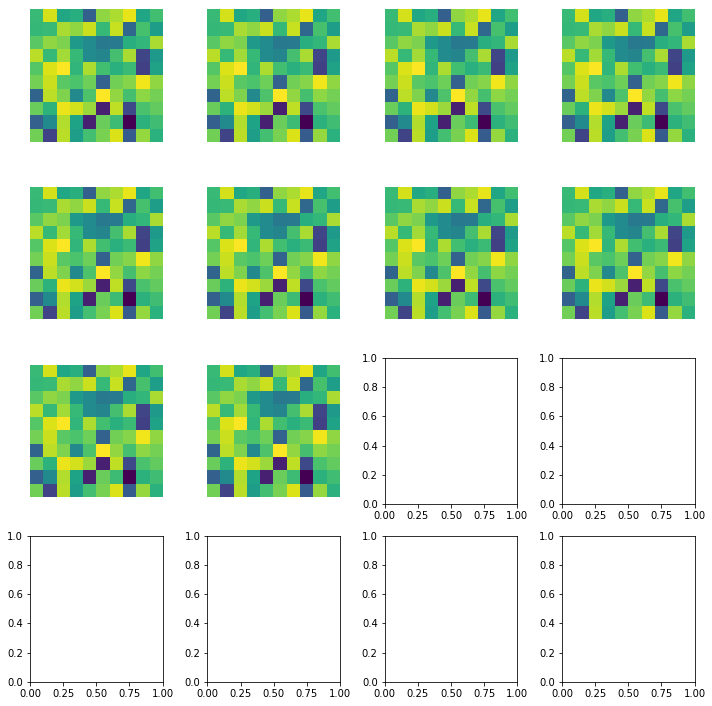

In [49]:

fc3 = augModel[1]
utils.helper.viewFCWeights(fc3)